In [8]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from scipy.stats import f_oneway

# Random Datasets concerning Hair Loss

In the real world, hair loss is a significant issue, particularly among males. It has been observed that males, especially those with high incomes, are more prone to experiencing hair loss. To explore this issue further, we have simulated data that corresponds to this pattern, specifically aiming to include a larger number of males with hair loss. In our dataset, Group A consists of individuals with median or low income, while Group B comprises individuals with high income. This simulation helps us analyze how income levels might influence hair loss severity among males.

In [9]:
np.random.seed(42)

n_samples = 10000
age = np.random.randint(18, 65, n_samples)  # working age
gender = np.random.choice(['Male', 'Female'], n_samples) 
income = np.random.randint(5000, 200000, n_samples)  # yearly salary:5k -- 200k
education_levels = ['None', 'High School', 'Bachelors', 'Masters', 'PhD']
education = np.random.choice(education_levels, n_samples)

# Assume factors that could be related to hair loss
stress_level = np.random.choice(['Low', 'Medium', 'High'], n_samples)  # stress levels
genetics = np.random.choice(['Low', 'Medium', 'High'], n_samples)  # genetic predisposition


random_probs= np.random.rand(6)
random_probs /= random_probs.sum()  # Scale to sum to 1

# Below is what we need to predict
hair_loss_level = np.random.choice([0, 1, 2, 3, 4, 5], n_samples, p=list(random_probs))

# Create DataFrame
data = pd.DataFrame({
    'Age': age,
    'Gender': gender,
    'Income': income,
    'Education': education,
    'Stress Level': stress_level,
    'Genetic Predisposition': genetics,
    'Hair Loss Level': hair_loss_level
})

data.head()

,Age,Gender,Income,Education,Stress Level,Genetic Predisposition,Hair Loss Level
0,56,Male,67461,Masters,Low,Low,5
1,46,Male,7665,PhD,Low,High,0
2,32,Female,32025,None,High,Low,1
3,60,Female,159605,None,Medium,Medium,3
4,25,Female,181969,Bachelors,Medium,Low,0


In [10]:
# In reality, male hair loss is much more severe than female, so we need to modify above data
severe_hair_loss_indices = data['Hair Loss Level'] >= 4
num_males_needed = int((0.85 * severe_hair_loss_indices.sum())) 
male_indices = data[data['Gender'] == 'Male'].index
selected_male_indices = np.random.choice(male_indices, num_males_needed, replace=False)
data.loc[severe_hair_loss_indices, 'Hair Loss Level'] = np.random.choice([0, 1, 2, 3, 4], size=severe_hair_loss_indices.sum())
data.loc[selected_male_indices, 'Hair Loss Level'] = 5



high_income_threshold = np.percentile(data['Income'], 70)
high_income_indices = data['Income'] > high_income_threshold

num_high_income_males_needed = int(0.65 * high_income_indices.sum())  # 65% males in high income category
female_high_income_indices = data[(data['Gender'] == 'Female') & high_income_indices].index
male_high_income_indices = data[(data['Gender'] == 'Male') & ~high_income_indices].index

if len(male_high_income_indices) >= num_high_income_males_needed:
    selected_high_income_males = np.random.choice(male_high_income_indices, num_high_income_males_needed, replace=False)
    data.loc[selected_high_income_males, 'Income'] = high_income_threshold + np.random.randint(1, 50000, num_high_income_males_needed)

# Divide into two groups A and B based on the new median income
new_median_income = data['Income'].median()
data['Group'] = data['Income'].apply(lambda x: 'A' if x <= new_median_income else 'B')

data.head()

,Age,Gender,Income,Education,Stress Level,Genetic Predisposition,Hair Loss Level,Group
0,56,Male,67461,Masters,Low,Low,5,A
1,46,Male,186600,PhD,Low,High,5,B
2,32,Female,32025,None,High,Low,1,A
3,60,Female,159605,None,Medium,Medium,3,B
4,25,Female,181969,Bachelors,Medium,Low,0,B


In [11]:
# Apply log-normal distribution to the age of males in group B
data.loc[(data['Gender'] == 'Male') & (data['Group'] == 'B'), 'Age'] = np.random.lognormal(mean=3.5, sigma=0.5, size=(data[(data['Gender'] == 'Male') & (data['Group'] == 'B')].shape[0]))

# Skew the income distribution
data['Income'] = np.where(data['Group'] == 'B', np.random.lognormal(mean=11, sigma=0.5, size=data.shape[0]), data['Income'])

# Introduce a complex interaction: High hair loss level primarily in males from Group B with high stress
data.loc[(data['Gender'] == 'Male') & (data['Group'] == 'B') & (data['Stress Level'] == 'High'), 'Hair Loss Level'] = np.random.choice([4, 5], size=(data[(data['Gender'] == 'Male') & (data['Group'] == 'B') & (data['Stress Level'] == 'High')].shape[0]))



In [12]:
# test median to see effects
data[data['Gender'] == 'Female']['Hair Loss Level'].median(), data[data['Gender'] == 'Male']['Hair Loss Level'].median()

(1.0, 4.0)

# Visualization

In [13]:
sns.set_style("whitegrid")

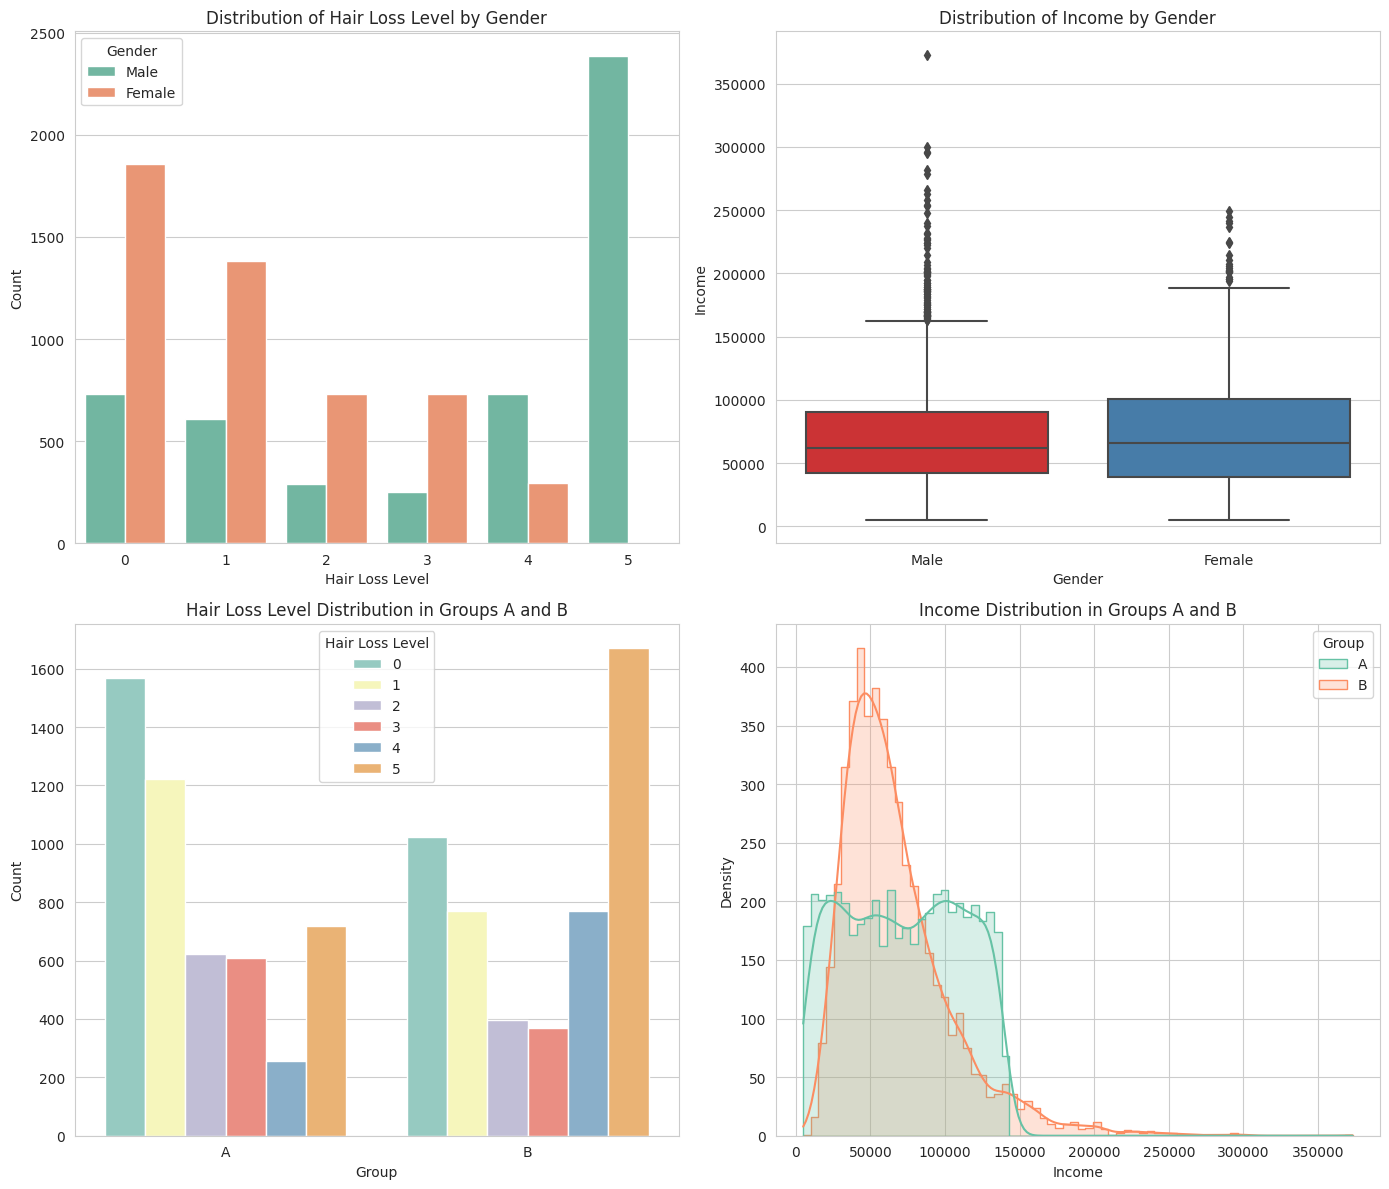

In [14]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 12))
sns.countplot(x='Hair Loss Level', hue='Gender', data=data, ax=axes[0, 0], palette='Set2')
axes[0, 0].set_title('Distribution of Hair Loss Level by Gender')
axes[0, 0].set_xlabel('Hair Loss Level')
axes[0, 0].set_ylabel('Count')


# Plot 2: Distribution of Income by Gender
sns.boxplot(x='Gender', y='Income', data=data, ax=axes[0, 1], palette='Set1')
axes[0, 1].set_title('Distribution of Income by Gender')
axes[0, 1].set_xlabel('Gender')
axes[0, 1].set_ylabel('Income')

# Plot 3: Hair Loss Level Distribution in Groups A and B
sns.countplot(x='Group', hue='Hair Loss Level', data=data, ax=axes[1, 0], palette='Set3')
axes[1, 0].set_title('Hair Loss Level Distribution in Groups A and B')
axes[1, 0].set_xlabel('Group')
axes[1, 0].set_ylabel('Count')

# Plot 4: Income Distribution in Groups A and B
sns.histplot(x='Income', hue='Group', data=data, kde=True, element='step', ax=axes[1, 1], palette='Set2')
axes[1, 1].set_title('Income Distribution in Groups A and B')
axes[1, 1].set_xlabel('Income')
axes[1, 1].set_ylabel('Density')

plt.tight_layout()
plt.show()

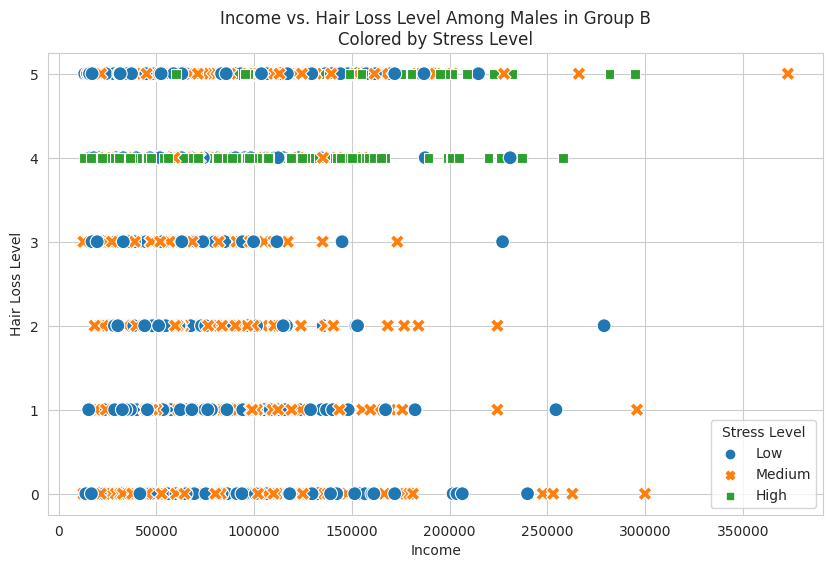

In [15]:

visual_data = data[(data['Gender'] == 'Male') & (data['Group'] == 'B')]

# Create a scatter plot for Income vs. Hair Loss Level, color by Stress Level
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Income', y='Hair Loss Level', hue='Stress Level', style='Stress Level', s=100, data=visual_data)
plt.title('Income vs. Hair Loss Level Among Males in Group B\nColored by Stress Level')
plt.xlabel('Income')
plt.ylabel('Hair Loss Level')
plt.grid(True)
plt.legend(title='Stress Level')
plt.show()

# Statistical Test

In [16]:
from scipy.stats import ttest_ind

# Data preparation for t-tests

# Hair Loss Level by Gender
male_hair_loss = data[data['Gender'] == 'Male']['Hair Loss Level']
female_hair_loss = data[data['Gender'] == 'Female']['Hair Loss Level']

# Education and Hair Loss Level
education_groups = {edu: data[data['Education'] == edu]['Hair Loss Level'] for edu in data['Education'].unique()}

# Income and Hair Loss Level
income_groups = {level: data[data['Hair Loss Level'] == level]['Income'] for level in data['Hair Loss Level'].unique()}

anova_education_hair_loss = f_oneway(*education_groups.values())
anova_income_hair_loss = f_oneway(*income_groups.values())

# Perform t-tests
t_test_hair_loss = ttest_ind(male_hair_loss, female_hair_loss, equal_var=False)

# Collect results
test_results = {
    'Hair Loss Level Between Genders': t_test_hair_loss,
    'Hair Loss Level Between Education': anova_education_hair_loss,
    'Hair Loss Level Between Income': anova_income_hair_loss
}

test_results


{'Hair Loss Level Between Genders': Ttest_indResult(statistic=64.6680806671496, pvalue=0.0),
 'Hair Loss Level Between Education': F_onewayResult(statistic=0.7813028030530462, pvalue=0.5371233944380011),
 'Hair Loss Level Between Income': F_onewayResult(statistic=0.651523936234588, pvalue=0.6603425134034085)}

Observations:

1. Distribution of Hair Loss Level by Gender: The plot above indicates a significant difference in hair loss levels between genders (p = 0.0). The text annotation points out that males are more likely to have severe hair loss, consistent with the statistical test results.

2. Distribution of Income by Gender: This boxplot shows that males and females are quite similar, However, more outliers (high level income) occur in males

3. Difference between Hair Loss Level and Education: Accroding to Anova test, there is no siginificant difference between different level education and hair loss level(p > 0.5)

4. Hair Loss Level Distribution in Incomes: There's a visible pattern where higher income levels among males in Group B tend to correlate with higher hair loss levels. This may suggest that higher economic status or related factors (possibly linked to stress) contribute to greater severity in hair loss. Also, the colors indicate stress levels, showing that higher stress often coincides with higher levels of hair loss. This supports the simulated condition that hair loss severity is influenced by stress among high-income males in Group B.


# Make prediction

Making prediction by age, gender etc VS hair loss level. 

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV

In [18]:
encoder = OneHotEncoder(sparse=False)
encoded_features = encoder.fit_transform(data[['Gender', 'Education', 'Stress Level', 'Genetic Predisposition', 'Group']])

/home/jiamingzhang/miniconda3/envs/zdt/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [19]:
X = np.hstack((encoded_features, data[['Age', 'Income']].values))  
y = data['Hair Loss Level'].values

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict on the testing set
y_pred = clf.predict(X_test)

# Calculate accuracy and confusion matrix
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

accuracy, conf_matrix

(0.3265,
 array([[183,  96,  44,  49,  27,  80],
        [171,  87,  22,  30,  13,  83],
        [103,  54,  20,  16,   7,  45],
        [ 77,  44,  23,  10,   3,  27],
        [ 28,  19,   5,   8,  61,  78],
        [ 60,  45,  12,  17,  61, 292]]))

We may need grid search to improve above accuracy, but in practice, we may need more complicated model(ANN etc) to do prediction. Due to time limitation, no time to training from scratch

In [22]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=3,  
                           verbose=2,  
                           n_jobs=-1) 


 
grid_search.fit(X_train, y_train)


best_rf = grid_search.best_estimator_ # Best model


y_pred_best = best_rf.predict(X_test)

# Calculate accuracy and confusion matrix for the best model
accuracy_best = accuracy_score(y_test, y_pred_best)
conf_matrix_best = confusion_matrix(y_test, y_pred_best)

best_rf, accuracy_best, conf_matrix_best

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.0s
[CV] END max_dep

(RandomForestClassifier(max_depth=10, min_samples_leaf=4, random_state=42),
 0.409,
 array([[300,  46,   0,   0,   0, 133],
        [233,  42,   1,   1,   1, 128],
        [151,  18,   0,   0,   0,  76],
        [113,  29,   0,   0,   0,  42],
        [ 44,   8,   0,   0,  60,  87],
        [  4,   0,   0,   0,  67, 416]]))